In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from src.preprocessing.process_sounds_metadata import generate_sounds_metadata, make_fixed_size_sounds
from src.preprocessing.filters import filter_recs_metadata
from src.preprocessing.load_data import load_recs_dict, load_sounds, load_traces_wavs_and_metadata
from src.data_representations.process_wavs import *
from src.deep_learning.tracing import predict_with_augmentation
from src.util import rgb2gray, make_image
import re
from skimage.transform import resize
import tensorflow as tf
%matplotlib inline



### Parameters

In [2]:
# path to metadata
DATA_FOLDER_NAME = 'data/'
path_to_recordings_metadata = PATH_TO_PROJECT + DATA_FOLDER_NAME
recordings_metadata_name = 'recordings_metadata.csv'


# Filters should be either 'all' or [val1, val2, ..., ]

colonies = 'all'
dates = 'all'
experiments = 'all'
#['single rat softchirps']
stages = ['split']
#fresh, split, split and checked, labeled, labeled and checked, traced, traced and check 
classes_to_trace = ['sound']
# Specify path to the model
sr = 22050
path_to_model = PATH_TO_PROJECT + '/models/tracer_mice/tracer.ckpt'
model = tf.keras.models.load_model(path_to_model)
img_shape = model.input_shape[1:-1]



OSError: SavedModel file does not exist at: /home/gr1/Projects/Naked-mole-rat-voices//models/tracer_mice/tracer.ckpt/{saved_model.pbtxt|saved_model.pb}

### Loading data

In [11]:
# load data
recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name)
filters_mask = filter_recs_metadata(recs_metadata, dates = dates, colonies = colonies, 
                                         stages = stages, experiments = experiments)
recs_to_trace = recs_metadata[filters_mask]
print(recs_to_trace.shape)
recs_to_trace.head(10)

(32, 8)


,name,date,ratids,colony,experiment,processing stage,path,number
11,C57pup_12-01-00_0214_0000012.npy,12-01-00,214,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
12,C57pup_01-01-00_0215_0000001.npy,01-01-00,215,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
13,FVBpup_06-01-00_0142_0000006.npy,06-01-00,142,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
14,FVBpup_11-01-00_0230_0000011.npy,11-01-00,230,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
15,FVBpup_11-01-00_0231_0000011.npy,11-01-00,231,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
16,C57pup_12-01-00_0210_0000012.npy,12-01-00,210,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
17,FVBpup_01-01-00_0230_0000001.npy,01-01-00,230,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
18,FVBpup_06-01-00_0232_0000006.npy,06-01-00,232,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
19,C57pup_12-01-00_0215_0000012.npy,12-01-00,215,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN
20,C57pup_06-01-00_0214_0000006.npy,06-01-00,214,mice,mice,split,/home/gr1/Projects/Naked-mole-rat-voices/mice_...,NaN


### Tracing

In [15]:
save = True

recs_metadata = pd.read_csv(path_to_recordings_metadata + recordings_metadata_name)
filters_mask = filter_recs_metadata(recs_metadata, dates = dates, colonies = colonies, 
                                    stages = stages, experiments = experiments)
recs_to_trace = recs_metadata[filters_mask]

for rec_name, rec_path in recs_to_trace[['name', 'path']].values:
    
    df_txt = pd.read_csv(rec_path + rec_name[:-3] + 'txt', sep = '\t')
    df_txt_to_trace = df_txt[df_txt['cl'].apply(lambda cl : cl in classes_to_trace)]
    
    if not len(df_txt_to_trace) and save:
        print('Empty txt for %s' % rec_name)
        recs_metadata['processing stage'].iloc[np.where(recs_metadata['name'] == rec_name)[0][0]] = 'traced'
        recs_metadata.to_csv(path_to_recordings_metadata + recordings_metadata_name, index  = None)
        continue
        
    print('Tracing %d softchirps from %s' % (len(df_txt_to_trace), rec_name))
    rec = np.load(rec_path + rec_name)
    
    sounds_npy = [rec[int(sr * s) : int(sr * e)] for (s,e) in df_txt_to_trace[['s', 'e']].values]
                  
    images = [make_image(s) for s in sounds_npy]
    images_resized = [resize(im, img_shape) for im in images]
    shapes_orig = [im.shape for im in images]
    
    traces = predict_with_augmentation(images_resized, model, times_augment = 20)
    traces_orig_shape = [resize(tr, sh) for tr, sh in zip(traces, shapes_orig)]
    trace_names = ['freshtrace_%s_%.4f_%4f_%s.png' % (cl, s, e, rec_name[:-4]) 
                   for s, e, cl in df_txt_to_trace.values]
    
    if not save:
        break
        
    for tr, tr_name in zip(traces_orig_shape, trace_names):
        plt.imsave(rec_path.replace('recordings/', 'traces/') + tr_name, tr, cmap = 'gray')
        
    recs_metadata['processing stage'].iloc[np.where(recs_metadata['name'] == rec_name)[0][0]] = 'traced'
    recs_metadata.to_csv(path_to_recordings_metadata + recordings_metadata_name, index  = None)

/home/gr1/tf2.1/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/gr1/tf2.1/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Empty txt for C57pup_12-01-00_0214_0000012.npy
Tracing 15 softchirps from C57pup_01-01-00_0215_0000001.npy
Tracing 489 softchirps from FVBpup_06-01-00_0142_0000006.npy


/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=511
  n_fft, y.shape[-1]


Tracing 2 softchirps from FVBpup_11-01-00_0230_0000011.npy
Empty txt for FVBpup_11-01-00_0231_0000011.npy
Tracing 14 softchirps from C57pup_12-01-00_0210_0000012.npy
Tracing 72 softchirps from FVBpup_01-01-00_0230_0000001.npy
Tracing 476 softchirps from FVBpup_06-01-00_0232_0000006.npy
Tracing 6 softchirps from C57pup_12-01-00_0215_0000012.npy
Tracing 268 softchirps from C57pup_06-01-00_0214_0000006.npy


/home/gr1/tf2.1/lib/python3.6/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=512 is too small for input signal of length=510
  n_fft, y.shape[-1]


Tracing 69 softchirps from FVBpup_07-01-00_0232_0000007.npy
Empty txt for FVBpup_11-01-00_0232_0000011.npy
Tracing 287 softchirps from FVBpup_03-01-00_0141_0000003.npy
Tracing 350 softchirps from C57pup_07-01-00_0214_0000007.npy
Tracing 513 softchirps from C57pup_08-01-00_0210_0000008.npy
Tracing 120 softchirps from C57pup_01-01-00_0214_0000001.npy
Tracing 337 softchirps from FVBpup_04-01-00_0230_0000004.npy
Tracing 289 softchirps from C57pup_05-01-00_0214_0000005.npy
Tracing 583 softchirps from FVBpup_08-01-00_0232_0000008.npy
Tracing 94 softchirps from C57pup_06-01-00_0215_0000006.npy
Tracing 225 softchirps from FVBpup_08-01-00_0141_0000008.npy
Tracing 435 softchirps from C57pup_07-01-00_0211_0000007.npy
Tracing 2 softchirps from C57pup_11-01-00_0215_0000011.npy
Tracing 1 softchirps from FVBpup_12-01-00_0142_0000012.npy
Tracing 243 softchirps from C57pup_06-01-00_0211_0000006.npy
Tracing 24 softchirps from C57pup_03-01-00_0213_0000003.npy
Tracing 85 softchirps from C57pup_02-01-00_02

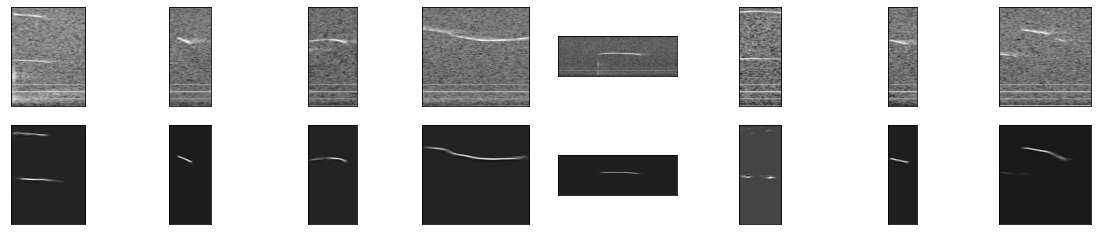

In [20]:
# run this cell to get random smaples from the last recording

inds = np.arange(0, len(images))
np.random.shuffle(inds)
n = 8
inds_to_take = inds[:n]
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    
    ind = inds_to_take[i - 1]
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(images[ind])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(traces_orig_shape[ind])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()